<a href="https://colab.research.google.com/github/AntoninoParisi/HMM_crypto_forecasting/blob/main/progetto_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Progetto Machine Learning - Cryptocurrency forecasting through HMM models

In [1]:
!pip install hmmlearn



In [2]:
import numpy as np
import scipy
import sklearn
from hmmlearn import hmm
import csv
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [3]:
# analisi dei dati #



## Dataset ##
dataset = []



with open('/content/coin_Ethereum.csv') as f:
  ds = csv.reader(f)
  next(ds,None) #skip line of column labels
  for row in ds:
      dataset.append(row)

dataset = np.array(dataset)
dataset = dataset[::-1]

print(dataset[1,:])


dataset = dataset[:,[4,5,6,7]]
print('dataset shape : ',dataset.shape)


dataset = dataset.astype(np.float)


deriv = np.diff(dataset[:,3],n=1)

deriv = deriv/np.max(deriv)




# features 

# next day price
test_data_full = dataset[0,:]
utils_data_full = dataset[1,:]


fracChange = (np.divide(dataset[:,3],dataset[:,2]) - 1) # close - open / open
fracHigh   = (np.divide(dataset[:,0],dataset[:,2]) - 1) # high - open / open
fracLow    = (1 - np.divide(dataset[:,1],dataset[:,2])) # open - low / open


'''
figure(figsize=(30, 25), dpi=150)

plt.scatter(np.arange(len(fracChange)),fracChange)
figure(figsize=(30, 25), dpi=150)

plt.scatter(np.arange(len(fracHigh)),fracHigh)
figure(figsize=(30, 25), dpi=150)

plt.scatter(np.arange(len(fracLow)),fracLow)'''




dataset = np.column_stack([fracChange, fracHigh, fracLow])
dataset = np.row_stack([dataset,dataset,dataset])

# next day features
test_data_idx = dataset[:3]

dataset = np.delete(dataset,0,0)
print(test_data_idx)


['2159' 'Ethereum' 'ETH' '2021-07-05 23:59:59' '2321.92283563'
 '2163.04139391' '2321.92283563' '2198.58246387' '20103794829.49'
 '256297846064.35']
dataset shape :  (2160, 4)
[[ 0.05767275  0.06750725  0.        ]
 [-0.05311993  0.          0.06842667]
 [ 0.04274493  0.07084343  0.01603947]]


In [4]:
print(test_data_full,test_data_idx,dataset[0,:])
print(dataset.shape)

[2346.29487431 2197.91938531 2197.91938531 2324.67944917] [[ 0.05767275  0.06750725  0.        ]
 [-0.05311993  0.          0.06842667]
 [ 0.04274493  0.07084343  0.01603947]] [-0.05311993  0.          0.06842667]
(6479, 3)


In [9]:
## Model inizialization ##
np.random.seed(432)
model = hmm.GMMHMM(algorithm='viterbi', covariance_type='spherical', covars_prior=0.001,
     n_components=4, n_iter=4000, n_mix=3
     , tol=0.001,verbose=True)

## Model paramaters definition ##
prob = np.random.rand(1,4)
prob = prob/prob.sum(axis=1)[:,None] #row wise sum is unitary

#model.startprob_ = prob

#model.transmat_ = np.array([[0.7, 0.2, 0.1],[0.3, 0.5, 0.2],[0.3, 0.3, 0.4]])

#model.means_ = np.array([[0.0, 0.0], [3.0, -3.0], [5.0, 10.0]])
#model.covars_ = np.tile(np.identity(2), (3, 1, 1))

print('dataset records : ' + str(len(dataset) ))


print(dataset.shape)

## fitting the model ##
#model.fit(np.diff(trainset,n=1,axis=0))
model.fit(dataset)





'''for i in range(model.n_components):
  print('#############################################################')
  print('Hidden state ',i)
  print('mean : ',round(model.means_[i][0],3))
  print('cov : ',round(np.diag(model.covars_[i])[0],3))'''






Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


dataset records : 6479
(6479, 3)


         1       31422.0286             +nan
         2       39857.8502       +8435.8216
         3       40887.0739       +1029.2238
         4       41119.5717        +232.4978
         5       41237.1118        +117.5401
         6       41329.0117         +91.9000
         7       41406.4765         +77.4647
         8       41474.7373         +68.2608
         9       41539.6053         +64.8680
        10       41606.6926         +67.0874
        11       41676.0654         +69.3727
        12       41736.7464         +60.6810
        13       41781.2961         +44.5497
        14       41815.4252         +34.1292
        15       41843.5282         +28.1029
        16       41867.2529         +23.7247
        17       41887.4324         +20.1795
        18       41904.7615         +17.3291
        19       41920.0199         +15.2584
        20       41934.0875         +14.0676
        21       41947.8246         +13.7371
        22       41961.8449         +14.0203
        23

"for i in range(model.n_components):\n  print('#############################################################')\n  print('Hidden state ',i)\n  print('mean : ',round(model.means_[i][0],3))\n  print('cov : ',round(np.diag(model.covars_[i])[0],3))"

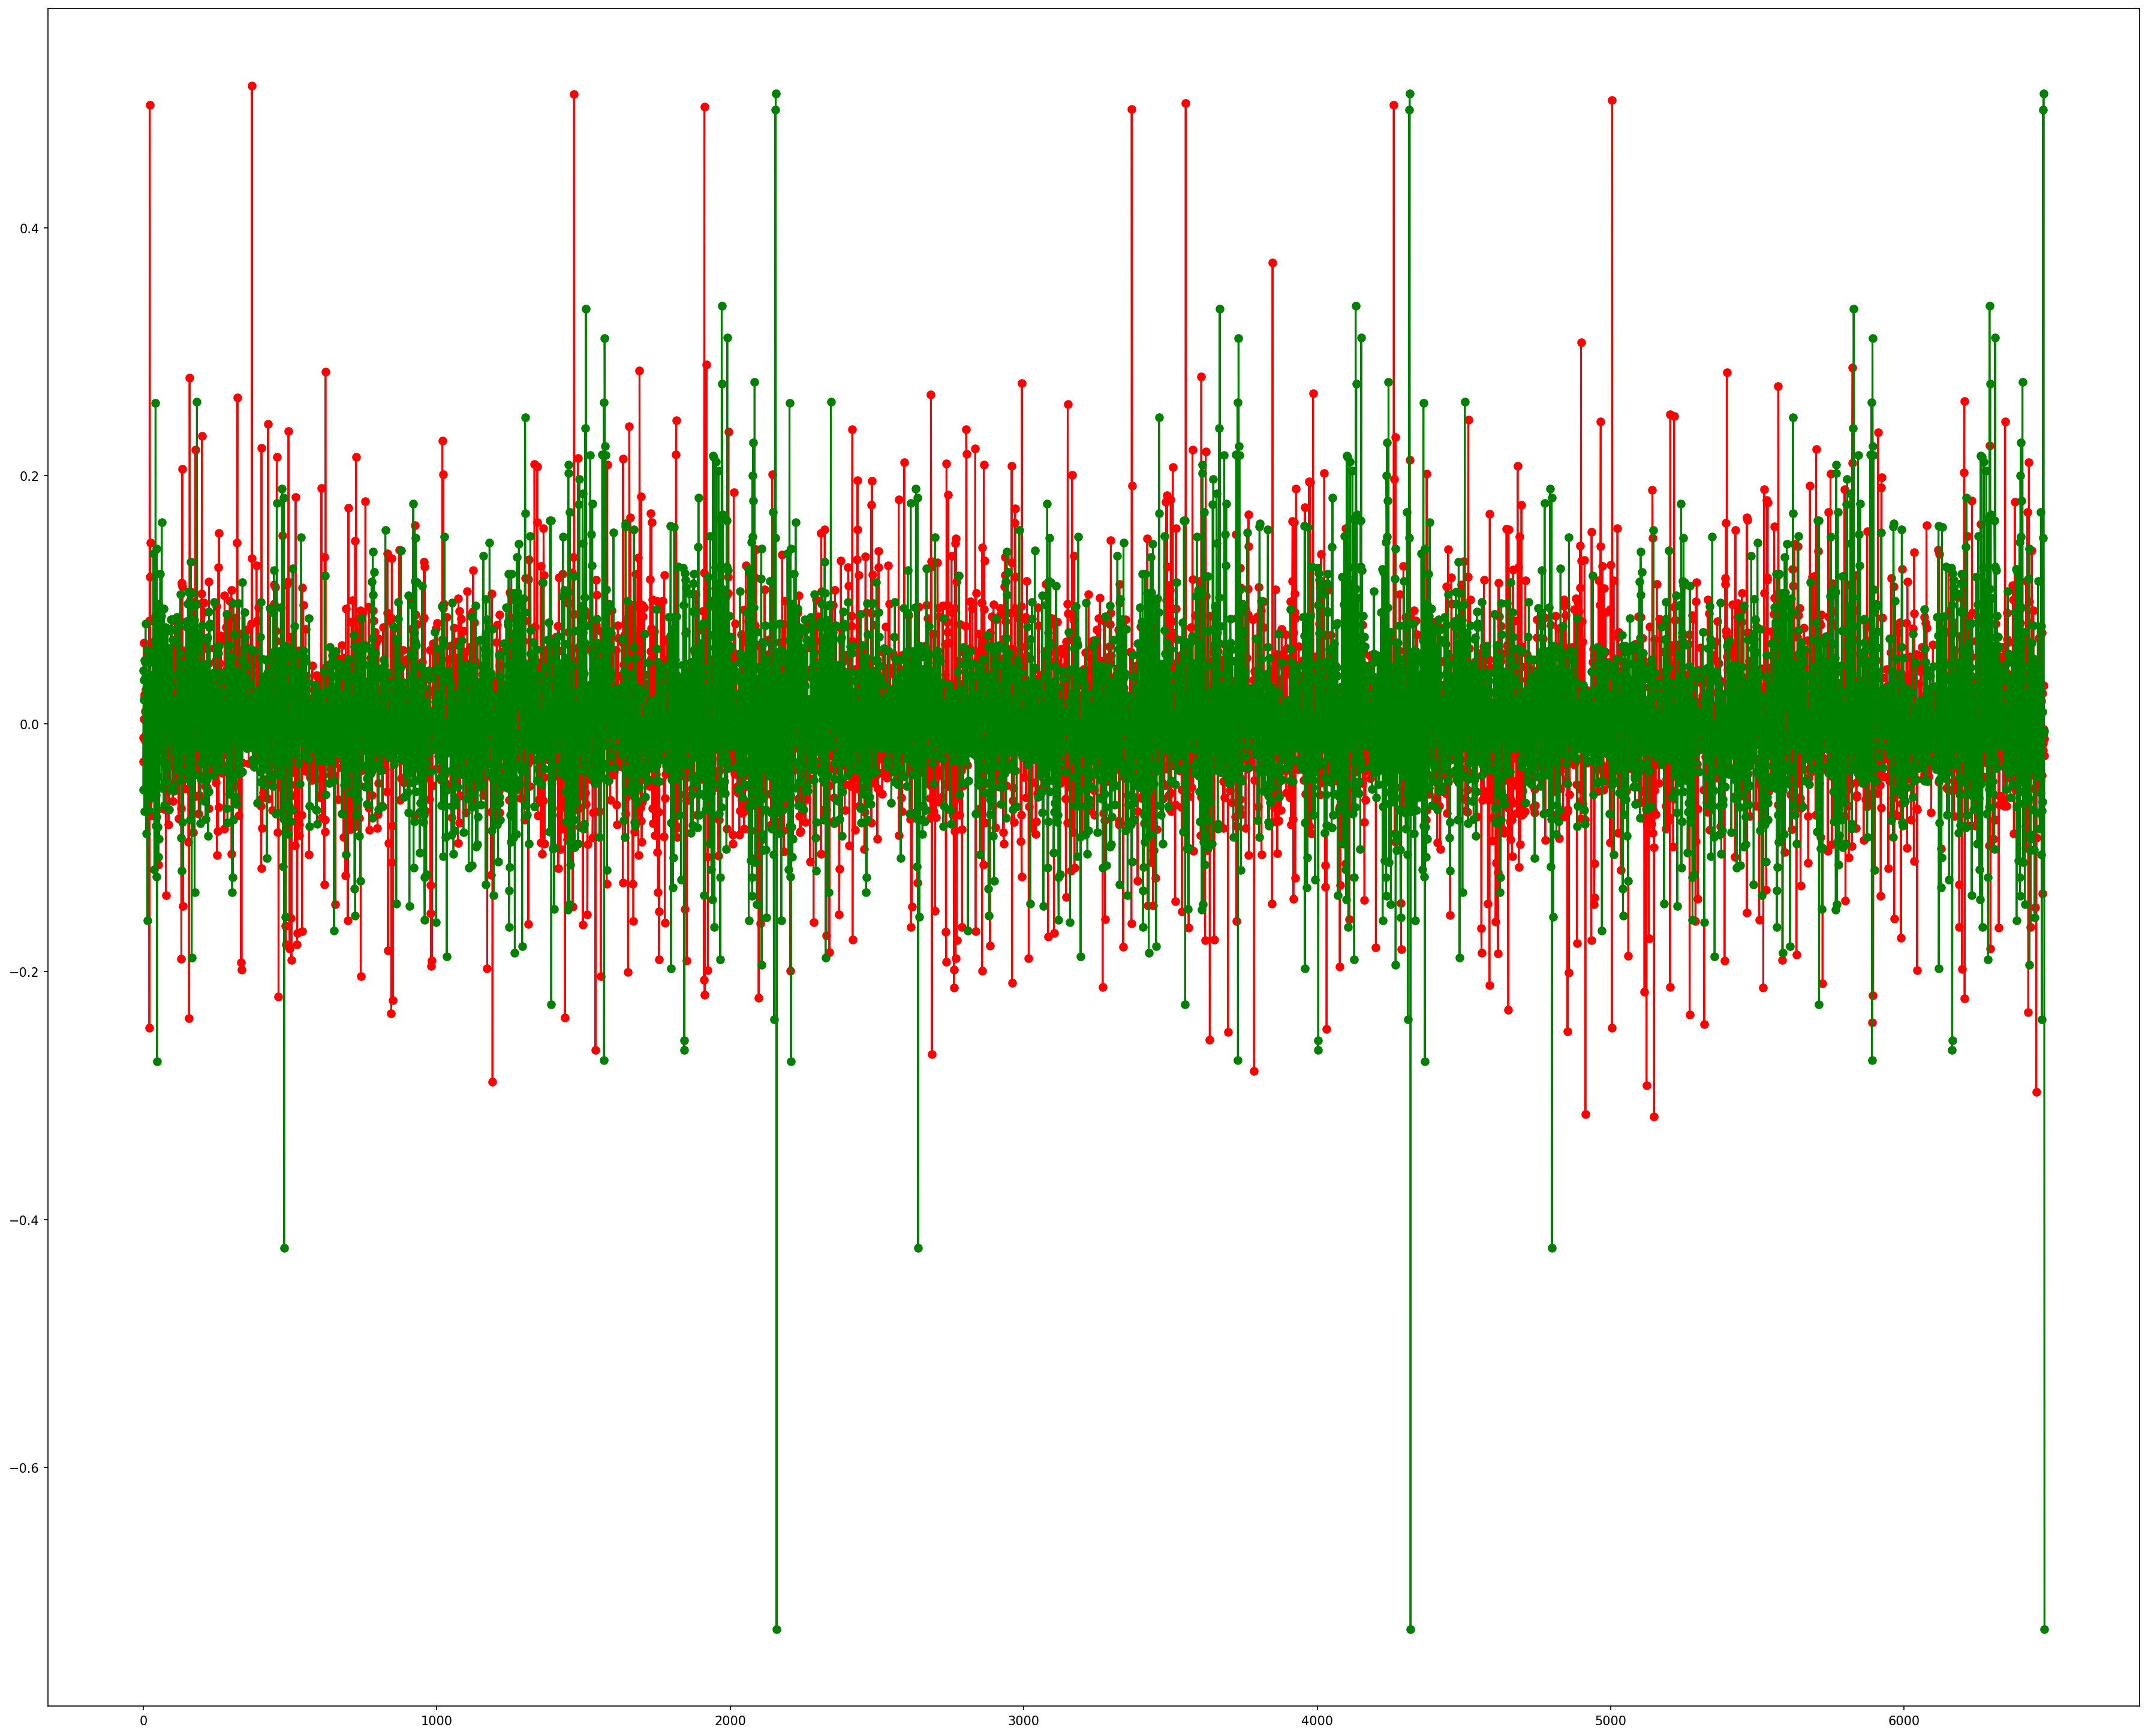

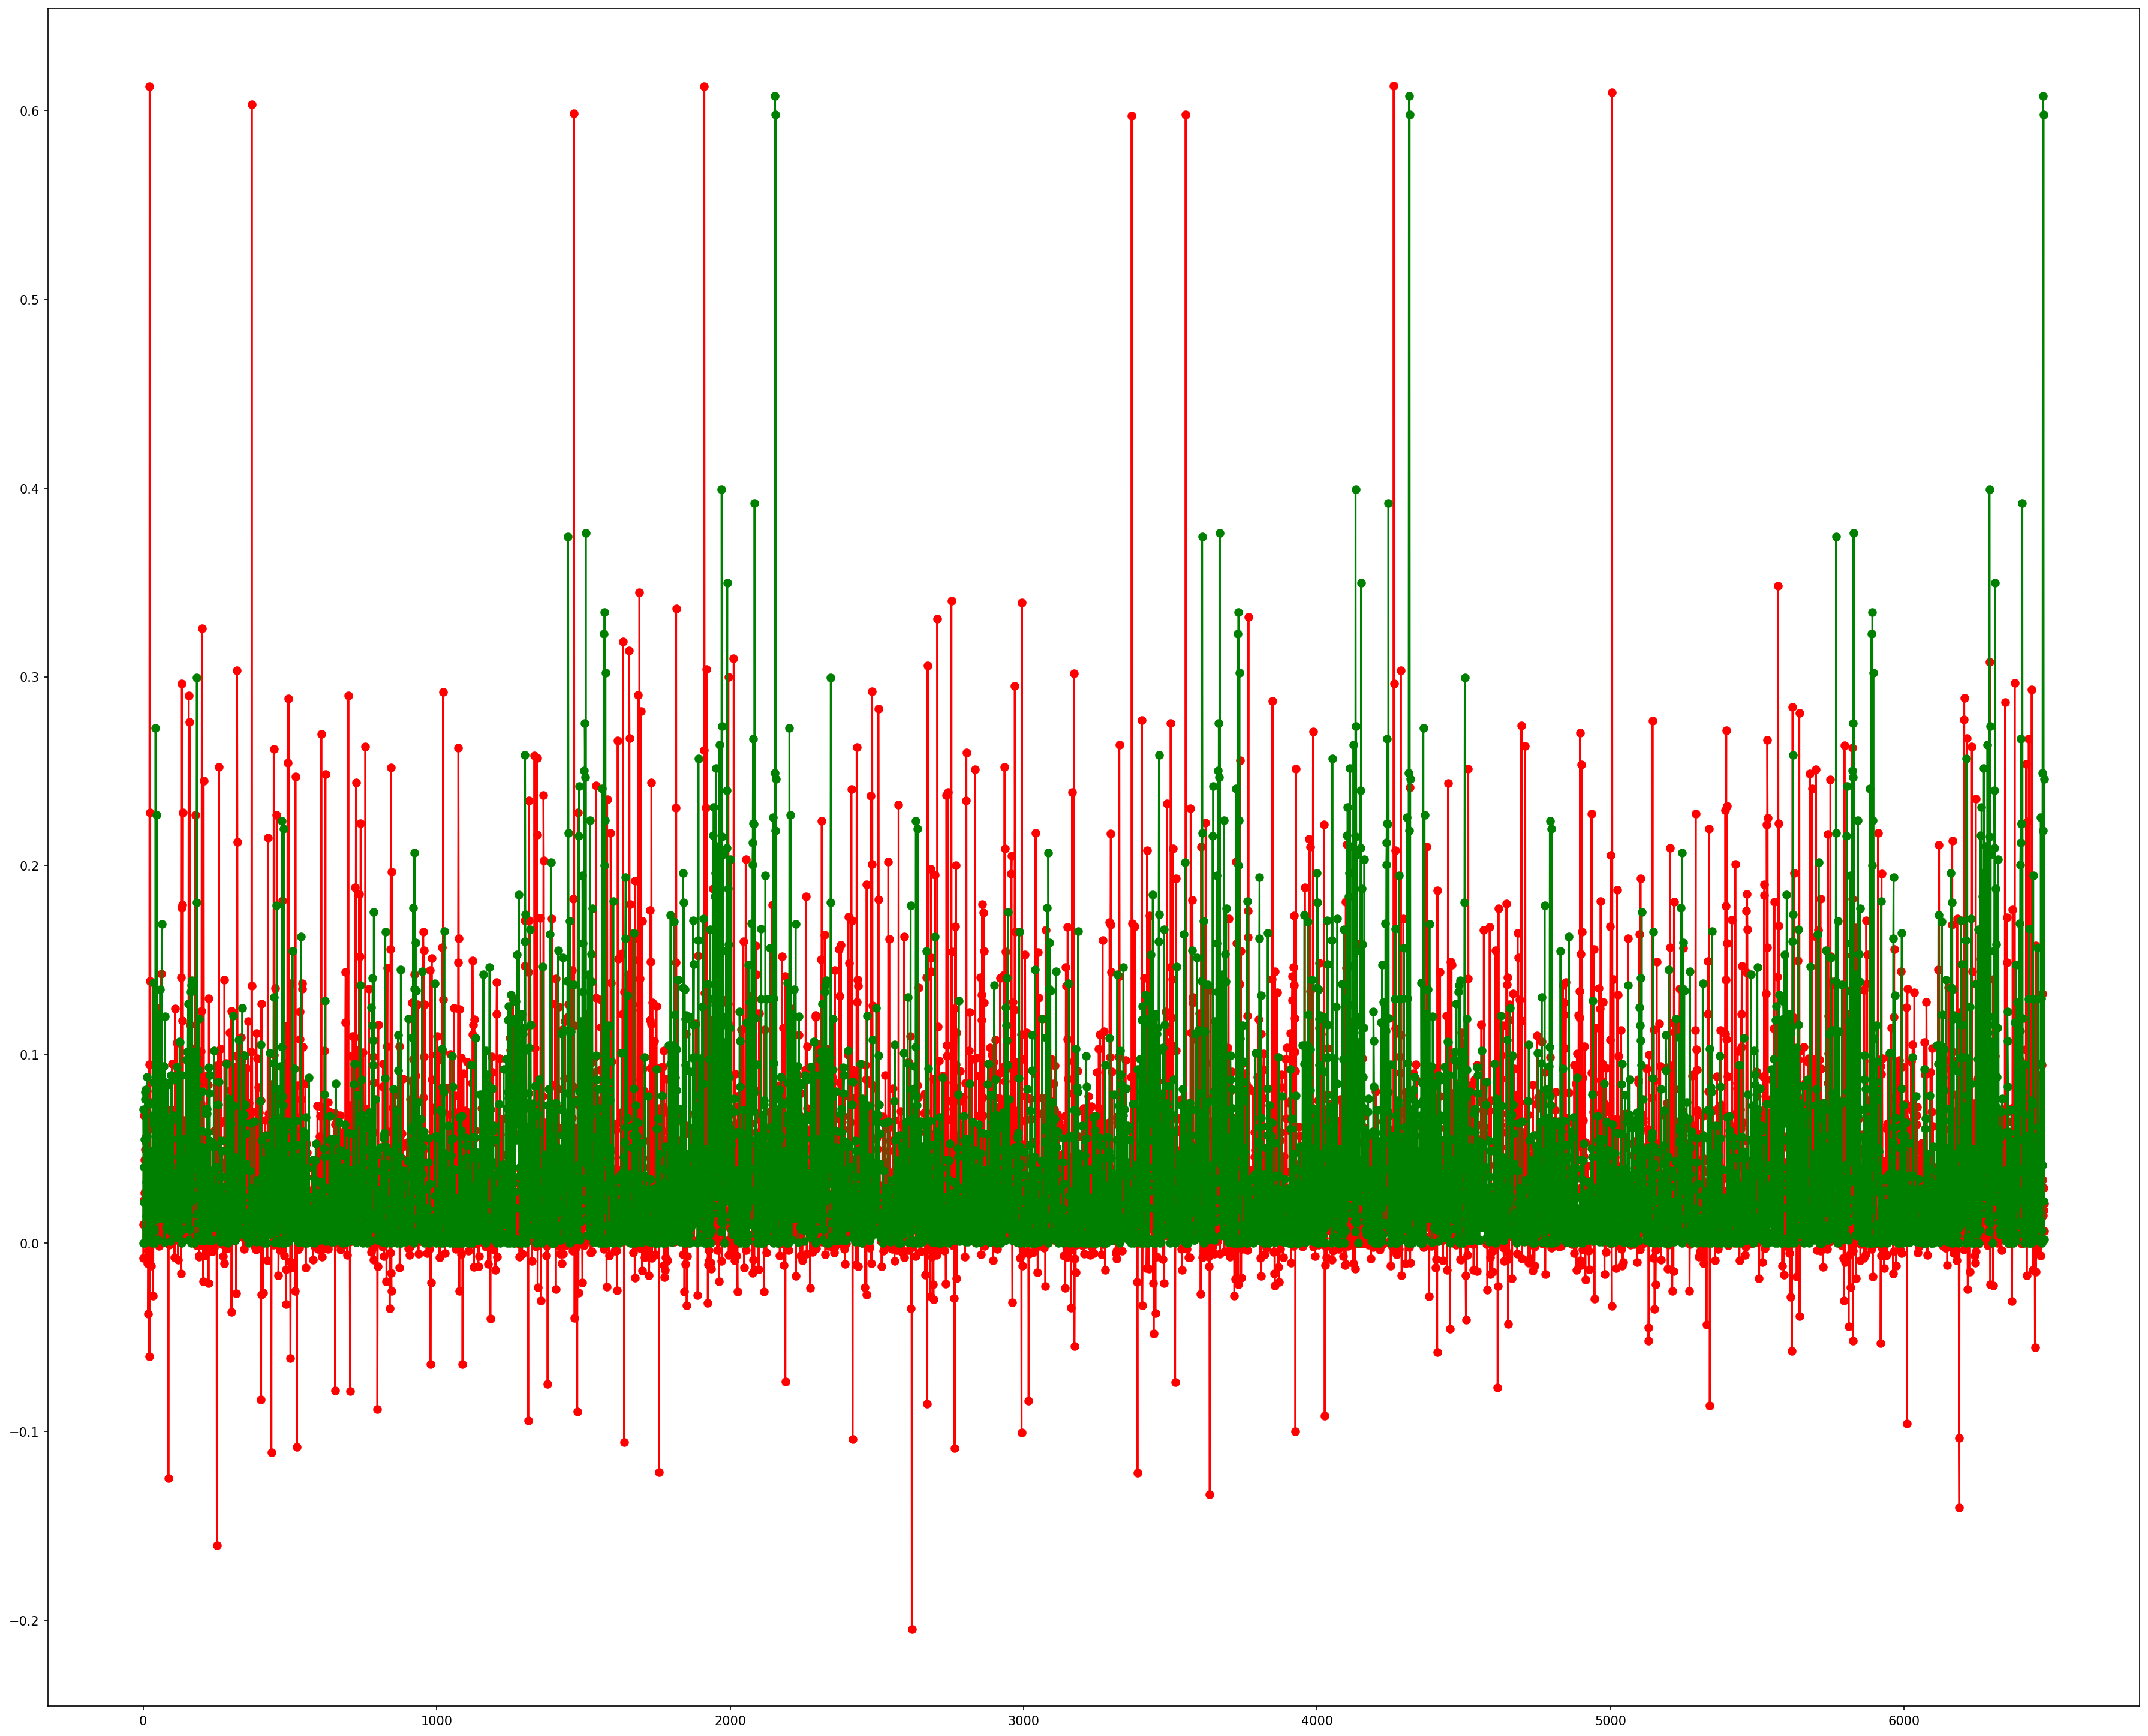

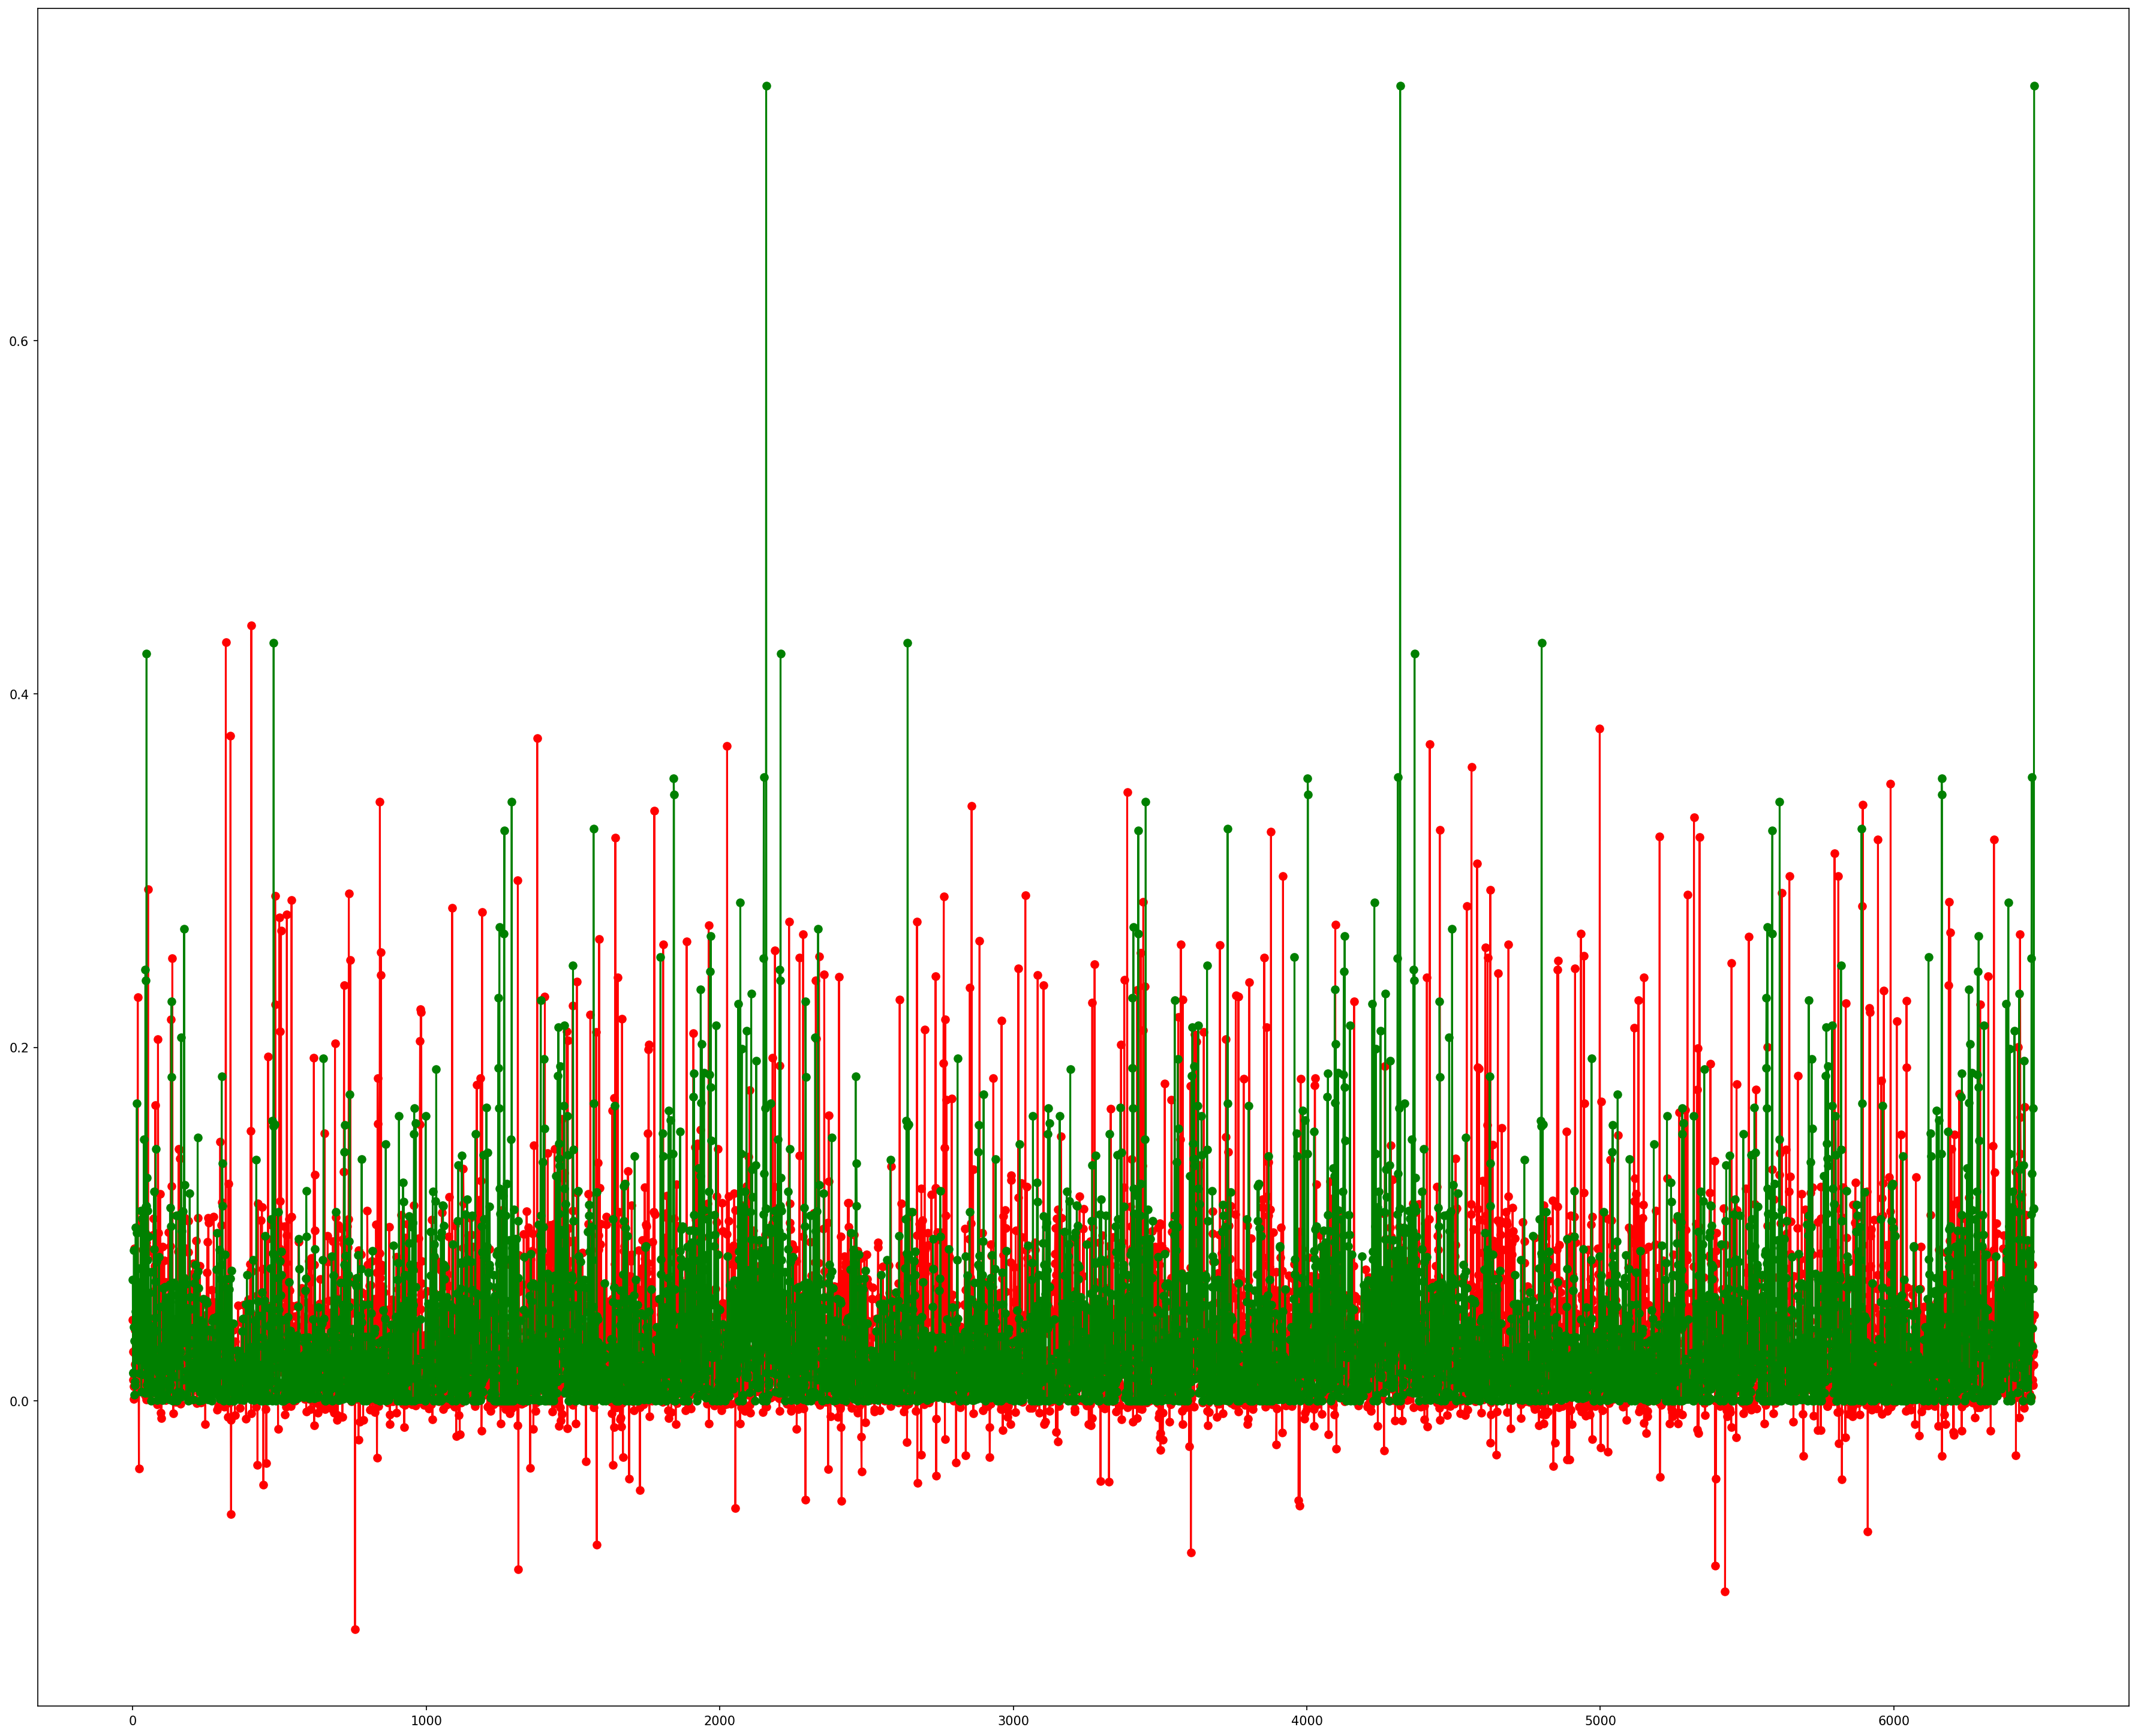

dim of sample dataset :  (6479, 3)
dim of dataset :  (6479, 3)
last predicted sample :  -0.025789763616325054
last real sample :  -0.7303544438374897


In [ ]:
# plotting the evolution of n samples starting from casual initial state #

n_samples = len(dataset)
samples,_ = model.sample(n_samples)



figure(figsize=(30, 25), dpi=150)


plt.plot(np.arange(n_samples),samples[:,0],color='red', marker='o')
plt.plot(np.arange(len(dataset)),dataset[:,0],color='green', marker='o')

figure(figsize=(30, 25), dpi=150)


plt.plot(np.arange(n_samples),samples[:,1],color='red', marker='o')
plt.plot(np.arange(len(dataset)),dataset[:,1],color='green', marker='o')

figure(figsize=(30, 25), dpi=150)


plt.plot(np.arange(n_samples),samples[:,2],color='red', marker='o')
plt.plot(np.arange(len(dataset)),dataset[:,2],color='green', marker='o')

plt.show()



print('dim of sample dataset : ',samples.shape)
print('dim of dataset : ',dataset.shape)

print('last predicted sample : ',samples[-1,0])

print('last real sample : ',dataset[-1,0])




In [6]:
x = np.mean(dataset[:,0])
y = np.mean(dataset[:,1])
z = np.mean(dataset[:,2])

predFracChange = np.linspace(-0.1,0.1, num=400)
predFracHigh   = np.linspace(-0.2,0.2, num=10)
predFracLow    = np.linspace(-0.2,0.2, num=10)

observations = []
for i in predFracChange:
    for j in predFracHigh:
        for k in predFracLow:
            observations.append([i,j,k])



observations = np.array(observations)
observationSeq = dataset[-30:]
observationSeq


array([[-0.03152439,  0.02662909,  0.03270524],
       [ 0.04548787,  0.04821331,  0.00731709],
       [ 0.00749449,  0.02971708,  0.02223051],
       [-0.02336334,  0.01142695,  0.06497886],
       [-0.04201039,  0.0024712 ,  0.06433264],
       [-0.00138165,  0.02900673,  0.01244939],
       [ 0.02789507,  0.05658476,  0.09109418],
       [ 0.11519968,  0.15638346,  0.01046501],
       [-0.00919961,  0.01146178,  0.03689892],
       [ 0.03809491,  0.05239357,  0.02366559],
       [-0.01890059,  0.01625902,  0.02779943],
       [ 0.02400276,  0.06152066,  0.06264173],
       [-0.07196753,  0.01075194,  0.08136031],
       [-0.08495904,  0.01277505,  0.08495904],
       [-0.01629821,  0.02523639,  0.05616726],
       [-0.01221804,  0.05738069,  0.03123275],
       [-0.05565405,  0.05340028,  0.0844117 ],
       [ 0.17083072,  0.22548313,  0.00227789],
       [ 0.07877939,  0.12945077,  0.        ],
       [-0.1055295 ,  0.09533448,  0.1055295 ],
       [-0.23879486,  0.        ,  0.250

In [7]:
score = -np.inf
best = []
for i in observations:
    seq = observationSeq
    seq = np.vstack([seq, i])
    s = model.score(seq)
    #print(s)
    if(s > score):
        best = i
        score = s
        print(best, score)



[-0.1 -0.2 -0.2] -31.933622119017233
[-0.1        -0.2        -0.15555556] -28.90547325367155
[-0.1        -0.2        -0.11111111] -26.265615749147482
[-0.1        -0.2        -0.06666667] -24.0140568738923
[-0.1        -0.2        -0.02222222] -22.15079924687655
[-0.1        -0.2         0.02222222] -20.675843773909147
[-0.1        -0.2         0.06666667] -19.58919075579353
[-0.1        -0.2         0.11111111] -18.890840288464627
[-0.1        -0.2         0.15555556] -18.580792401313385
[-0.1        -0.15555556  0.06666667] -17.837449095978897
[-0.1        -0.15555556  0.11111111] -17.139098713370117
[-0.1        -0.15555556  0.15555556] -16.829050849504345
[-0.1        -0.11111111  0.06666667] -16.474009355670315
[-0.1        -0.11111111  0.11111111] -15.775659573989833
[-0.1        -0.11111111  0.15555556] -15.465611849923771
[-0.1        -0.06666667  0.11111111] -14.800438930950149
[-0.1        -0.06666667  0.15555556] -14.490475184446725
[-0.1        -0.02222222  0.06666667] -1

In [8]:
# inverse formula to forecast the next day feature


print('next day forecast index : ',best)
print('next day real index : ',test_data_idx)



chiusura = utils_data_full[3]*(best[0]+1) # chiusura di ieri = apertura di oggi cosi calcolo la previsione di chiusura odierna

print('next day forecast full version : ',chiusura)
print('next day real full version : ',test_data_full[3])



next day forecast index :  [-0.00576441  0.02222222  0.02222222]
next day real index :  [[ 0.05767275  0.06750725  0.        ]
 [-0.05311993  0.          0.06842667]
 [ 0.04274493  0.07084343  0.01603947]]
next day forecast full version :  2185.9089308702482
next day real full version :  2324.67944917
